import libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

important functions

In [29]:
def wilson(x1,v1,v2,a12,a21,temp):
    x2=1-x1
    delta12 = (v2/v1)*math.e**(-a12/(8.314*temp))
    delta21 = (v1/v2)*math.e**(-a21/(8.314*temp))
    ln_gamma1 = -1*math.log(x1+x2*delta12)+x2*((delta12/(x1+x2*delta12))-(delta21/(x2+x1*delta21)))
    ln_gamma2 = -1*math.log(x2+x1*delta21)-x1*((delta12/(x1+x2*delta12))-(delta21/(x2+x1*delta21)))
    return math.e**(ln_gamma1), math.e**(ln_gamma2)

def nrtl(x1,b12,b21,alpha,temp):
    x2 = 1-x1
    tau12 = b12/(8.314*temp)
    tau21 = b21/(8.314*temp)
    g12 = math.e**(-1*alpha*tau12)
    g21 = math.e**(-1*alpha*tau21)
    ln_gamma1 = (x2**2)*(tau21*(g21/(x1+x2*g21))**2 + ((g12*tau12)/((x2+x1*g12)**2)))
    ln_gamma2 = (x1**2)*(tau12*(g12/(x2+x1*g12))**2 + ((g21*tau21)/((x1+x2*g21)**2)))
    return math.e**(ln_gamma1), math.e**(ln_gamma2)

def vap_pressure(A,B,C,temp):
    temp = temp - 273.15
    ln_psat = A-B/(temp+C)
    return math.e**(ln_psat)

def boiling_pt(A,B,C,psat):
    return (B/(A-math.log(psat))-C) + 273.15

initializing data

In [30]:
component1 = input("enter component 1")
component2 = input("enter component 2")
print(component1,component2)
required = ["v1","v2","a12","a21","b12","b21","alpha", "A1","B1","C1","A2","B2","C2"]
values = {}
# for i in required:
#     values[i] = float(input(f"enter value of {i} for your components"))
values = {'v1': 74.05, 'v2': 18.07, 'a12': 1219.5, 'a21':6062.5,'b12': 2642.1, 'b21': 5013.3, 'alpha': 0.5343 ,'A1': 14.3154,  'B1': 2756.22, 'C1': 228.06, 'A2': 16.3872, 'B2': 3885.7,'C2': 230.17}


2 4


In [31]:
print(values)

{'v1': 74.05, 'v2': 18.07, 'a12': 1219.5, 'a21': 6062.5, 'b12': 2642.1, 'b21': 5013.3, 'alpha': 0.5343, 'A1': 14.3154, 'B1': 2756.22, 'C1': 228.06, 'A2': 16.3872, 'B2': 3885.7, 'C2': 230.17}


12.12

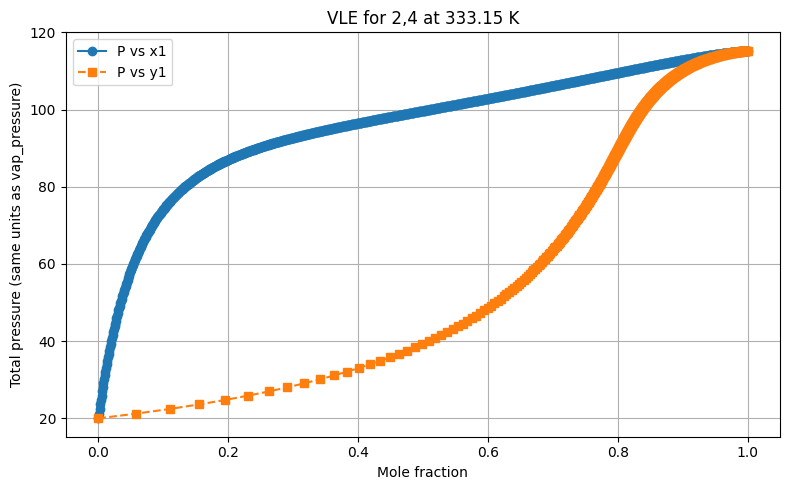

           x1        y1    pressure
0    0.000000  0.000000   20.007045
1    0.001001  0.058715   21.233869
2    0.002002  0.109895   22.432691
3    0.003003  0.154902   23.604334
4    0.004004  0.194785   24.749589
..        ...       ...         ...
995  0.995996  0.996528  115.200858
996  0.996997  0.997388  115.215912
997  0.997998  0.998253  115.230686
998  0.998999  0.999124  115.245175
999  1.000000  1.000000  115.259377

[1000 rows x 3 columns]


In [32]:
temp = 333.15

p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)

x1 = np.linspace(0, 1, num=1000)
gamma1 = [wilson(x, values["v1"], values["v2"], values["a12"], values["a21"], temp)[0] for x in x1]
gamma2 = [wilson(x, values["v1"], values["v2"], values["a12"], values["a21"], temp)[1] for x in x1]

pb = [ x1[i]*gamma1[i]*p1sat + (1-x1[i])*p2sat*gamma2[i] for i in range(len(x1)) ]
y1 = [(x1[i]*p1sat*gamma1[i])/pb[i] for i in range(len(x1))]
result = pd.DataFrame({"x1":x1, "y1":y1 , "pressure":pb})

plt.figure(figsize=(8,5))
plt.plot(x1, pb, marker='o', linestyle='-', label='P vs x1')
plt.plot(y1, pb, marker='s', linestyle='--', label='P vs y1')
plt.xlabel('Mole fraction')
plt.ylabel('Total pressure (same units as vap_pressure)')
plt.title(f'VLE for {component1},{component2} at {temp:.2f} K')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(result)

12.13

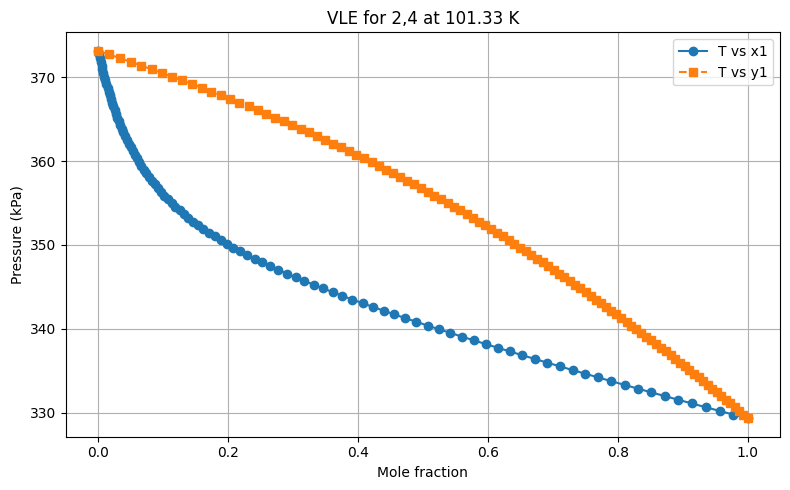

              x1            y1  temperature
0   1.000000e+00  1.000000e+00   329.323787
1   9.783906e-01  9.933973e-01   329.766467
2   9.569243e-01  9.867457e-01   330.209147
3   9.356023e-01  9.800456e-01   330.651827
4   9.144259e-01  9.732975e-01   331.094507
..           ...           ...          ...
95  5.304136e-03  6.636710e-02   371.378390
96  3.923853e-03  5.010466e-02   371.821070
97  2.580790e-03  3.362438e-02   372.263750
98  1.273344e-03  1.692368e-02   372.706430
99  1.563803e-16  2.119787e-15   373.149111

[100 rows x 3 columns]


In [33]:
p = 101.33
t1sat = boiling_pt(values["A1"], values["B1"], values["C1"], p)
t2sat = boiling_pt(values["A2"], values["B2"], values["C2"], p)

temp = np.linspace(t1sat, t2sat, 100)

p1sat = [ vap_pressure(values["A1"], values["B1"], values["C1"], temp[i]) for i in range(len(temp))]
p2sat = [ vap_pressure(values["A2"], values["B2"], values["C2"], temp[i]) for i in range(len(temp))]

for i in range(10):
    if i==0:
        gamma2 = gamma1 = 1
        x1 = [(p - gamma2 * p2sat[i]) / (gamma1 * p1sat[i] - gamma2 * p2sat[i]) for i in range(len(temp)) ]
    else:
        gamma1 = [wilson(x1[i], values["v1"], values["v2"], values["a12"], values["a21"], temp[i]+273.15)[0] for i in range(len(temp))] 
        gamma2 = [wilson(x1[i], values["v1"], values["v2"], values["a12"], values["a21"], temp[i]+273.15)[1] for i in range(len(temp)) ] 
        x1 = [(p - gamma2[i] * p2sat[i]) / (gamma1[i] * p1sat[i] - gamma2[i] * p2sat[i]) for i in range(len(temp)) ]

y1 = [x1[i]*p1sat[i]*gamma1[i]/p for i in range(len(temp))]
result = pd.DataFrame({"x1":x1, "y1":y1 , "temperature":temp})
plt.figure(figsize=(8,5))
plt.plot(x1, temp, marker='o', linestyle='-', label='T vs x1')
plt.plot(y1, temp, marker='s', linestyle='--', label='T vs y1')
plt.xlabel('Mole fraction')
plt.ylabel('Pressure (kPa)')
plt.title(f'VLE for {component1},{component2} at {p:.2f} K')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(result)

12.14

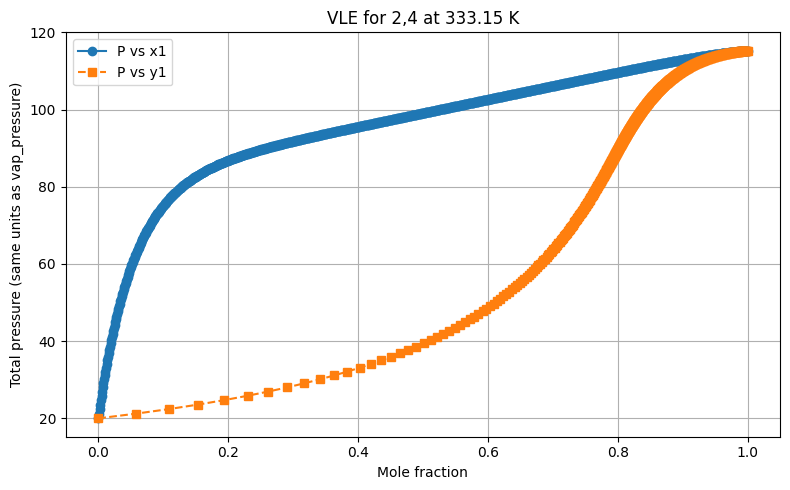

           x1        y1    pressure
0    0.000000  0.000000   20.007045
1    0.001001  0.058312   21.224775
2    0.002002  0.109304   22.417744
3    0.003003  0.154268   23.586527
4    0.004004  0.194210   24.731687
..        ...       ...         ...
995  0.995996  0.996461  115.209029
996  0.996997  0.997336  115.222109
997  0.997998  0.998218  115.234863
998  0.998999  0.999106  115.247287
999  1.000000  1.000000  115.259377

[1000 rows x 3 columns]


In [34]:
temp = 333.15

p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)

x1 = np.linspace(0, 1, num=1000)
gamma1 = [nrtl(x, values["b12"], values["b21"], values["alpha"], temp)[0] for x in x1]
gamma2 = [nrtl(x, values["b12"], values["b21"], values["alpha"], temp)[1] for x in x1]

pb = [ x1[i]*gamma1[i]*p1sat + (1-x1[i])*p2sat*gamma2[i] for i in range(len(x1)) ]
y1 = [(x1[i]*p1sat*gamma1[i])/pb[i] for i in range(len(x1))]
result = pd.DataFrame({"x1":x1, "y1":y1 , "pressure":pb})

plt.figure(figsize=(8,5))
plt.plot(x1, pb, marker='o', linestyle='-', label='P vs x1')
plt.plot(y1, pb, marker='s', linestyle='--', label='P vs y1')
plt.xlabel('Mole fraction')
plt.ylabel('Total pressure (same units as vap_pressure)')
plt.title(f'VLE for {component1},{component2} at {temp:.2f} K')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(result)

12.15

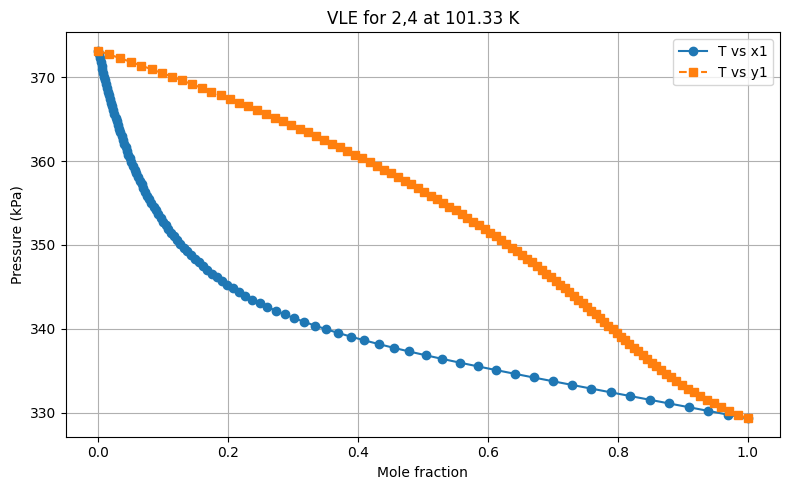

              x1            y1  temperature
0   1.000000e+00  1.000000e+00   329.323787
1   9.697269e-01  9.853966e-01   329.766467
2   9.396015e-01  9.719790e-01   330.209147
3   9.095523e-01  9.595511e-01   330.651827
4   8.795349e-01  9.479611e-01   331.094507
..           ...           ...          ...
95  5.202989e-03  6.632281e-02   371.378390
96  3.868477e-03  5.008008e-02   371.821070
97  2.556952e-03  3.361371e-02   372.263750
98  1.267691e-03  1.692119e-02   372.706430
99  1.564242e-16  2.119831e-15   373.149111

[100 rows x 3 columns]


In [35]:
p = 101.33
t1sat = boiling_pt(values["A1"], values["B1"], values["C1"], p)
t2sat = boiling_pt(values["A2"], values["B2"], values["C2"], p)

temp = np.linspace(t1sat, t2sat, 100)

p1sat = [ vap_pressure(values["A1"], values["B1"], values["C1"], temp[i]) for i in range(len(temp))]
p2sat = [ vap_pressure(values["A2"], values["B2"], values["C2"], temp[i]) for i in range(len(temp))]

for i in range(10):
    if i==0:
        gamma2 = gamma1 = 1
        x1 = [(p - gamma2 * p2sat[i]) / (gamma1 * p1sat[i] - gamma2 * p2sat[i]) for i in range(len(temp)) ]
    else:
        gamma1 = [nrtl(x1[i], values["b12"], values["b21"], values["alpha"], temp[i]+273.15)[0] for i in range(len(temp))] 
        gamma2 = [nrtl(x1[i], values["b12"], values["b21"], values["alpha"], temp[i]+273.15)[1] for i in range(len(temp)) ] 
        x1 = [(p - gamma2[i] * p2sat[i]) / (gamma1[i] * p1sat[i] - gamma2[i] * p2sat[i]) for i in range(len(temp)) ]

y1 = [x1[i]*p1sat[i]*gamma1[i]/p for i in range(len(temp))]
result = pd.DataFrame({"x1":x1, "y1":y1 , "temperature":temp})
plt.figure(figsize=(8,5))
plt.plot(x1, temp, marker='o', linestyle='-', label='T vs x1')
plt.plot(y1, temp, marker='s', linestyle='--', label='T vs y1')
plt.xlabel('Mole fraction')
plt.ylabel('Pressure (kPa)')
plt.title(f'VLE for {component1},{component2} at {p:.2f} K')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(result)

12.16

In [63]:
temp = 333.15
# (a)
x1 = 0.3
p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)
gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], temp)
pb = x1*p1sat*gamma1 + (1-x1)*p2sat*gamma2
print(f"bubble pressure for (a) is {pb} kelvin")

# (b)
y1 = 0.3
for i in range(10):
    if i==0:
        gamma2 = gamma1 = 1
        p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))
        x1 = (y1*p_dew)/(p1sat*gamma1)
    else:
        gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], temp)
        p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))
        x1 = (y1*p_dew)/(p1sat*gamma1)
print(f"dew pressure for (b) is {p_dew} kelvin")
# (c)
t_flash = temp
p_flash = (pb + p_dew) / 2
p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], t_flash)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], t_flash)
z1 = 0.3

for i in range(100):
    gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], t_flash) if i==0 else (1,1)
    k1, k2 = gamma1*p1sat/p_flash, gamma2*p2sat/p_flash
    for v in np.linspace(0,1,1000):
        summation = z1*k1/(1+v*(k1-1)) + (1-z1)*k2/(1+v*(k2-1))
        if abs(summation-1) < 0.001:
            print(i,"breaking value of flash v ->", v)
            y1 = z1*k1/(1+v*(k1-1))
            x1 = (p_flash*y1)/(p1sat*gamma1)
            print(" ",x1,y1)
            continue

bubble pressure for (a) is 92.71090069859721 kelvin
dew pressure for (b) is 28.380328490528935 kelvin
0 breaking value of flash v -> 0.4094094094094094
  0.035547382077965414 0.6814842165623481
0 breaking value of flash v -> 0.41041041041041043
  0.03547093235570298 0.6800185874207095
0 breaking value of flash v -> 1.0
  0.015648513001788603 0.3
1 breaking value of flash v -> 1.0
  0.15758964501823278 0.3
2 breaking value of flash v -> 1.0
  0.15758964501823278 0.3
3 breaking value of flash v -> 1.0
  0.15758964501823278 0.3
4 breaking value of flash v -> 1.0
  0.15758964501823278 0.3
5 breaking value of flash v -> 1.0
  0.15758964501823278 0.3
6 breaking value of flash v -> 1.0
  0.15758964501823278 0.3
7 breaking value of flash v -> 1.0
  0.15758964501823278 0.3
8 breaking value of flash v -> 1.0
  0.15758964501823278 0.3
9 breaking value of flash v -> 1.0
  0.15758964501823278 0.3
10 breaking value of flash v -> 1.0
  0.15758964501823278 0.3
11 breaking value of flash v -> 1.0
  0.1

12.17

In [37]:
temp = 333.15
# (a)
x1 = 0.3
p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)
gamma1, gamma2 = nrtl(x1, values["b12"], values["b21"], values["alpha"], temp)
pb = x1*p1sat*gamma1 + (1-x1)*p2sat*gamma2

# (b)
y1 = 0.3
for i in range(100):
    if i==0:
        gamma2 = gamma1 = 1
        p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))
        x1 = (y1*p_dew)/(p1sat*gamma1)
    else:
        gamma1, gamma2 = nrtl(x1, values["b12"], values["b21"], values["alpha"], temp)
        p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))
        x1 = (y1*p_dew)/(p1sat*gamma1)

# (c)
t_flash = temp
p_flash = (pb + p_dew) / 2
p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], t_flash)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], t_flash)
gamma1, gamma2 = nrtl(x1, values["b12"], values["b21"], values["alpha"], t_flash)
z1 = 0.3
k1, k2 = p1sat/p_flash, p2sat/p_flash

for v in np.linspace(0,1,10000):
    summation = gamma1*x1*k1/(1+v*(k1-1)) + gamma2*(1-x1)*k2/(1+v*(k2-1))
    if abs(summation-1) < 0.0001:
        print("breaking", v)
        break

breaking 0.9631963196319633


12.18

In [38]:
p = 101.33
# (a)
x1 = 0.3
t1sat = boiling_pt(values["A1"], values["B1"], values["C1"], p)
t2sat = boiling_pt(values["A2"], values["B2"], values["C2"], p)
t_avg = 0.5*(t1sat+t2sat)
temp = t_avg
temp_old = 0

while abs(temp-temp_old) > 0.001:
    p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
    p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)

    gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], temp)

    relative_volatility = p1sat/p2sat
    p1sat = p*(x1*gamma1 + (1-x1)*gamma2/relative_volatility)

    temp_old = temp
    temp = boiling_pt(values["A1"], values["B1"], values["C1"], p1sat)
tb = temp
print(f"bubble temperature for (a) is {temp} kelvin")

# (b)
y1 = 0.3
t1sat = boiling_pt(values["A1"], values["B1"], values["C1"], p)
t2sat = boiling_pt(values["A2"], values["B2"], values["C2"], p)
t_avg = 0.5*(t1sat+t2sat)
temp = t_avg
temp_old = 0
gamma1, gamma2 = 1, 1
while abs(temp-temp_old) > 0.001:
    p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
    p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)

    p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))

    x1 = y1*p_dew/(p1sat*gamma1)
    x2 = 1-x1

    gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], temp)

    relative_volatility = p1sat/p2sat
    p1sat = p*(y1/gamma1 + ((1-y1)*relative_volatility)/gamma2)

    temp_old = temp
    temp = boiling_pt(values["A1"], values["B1"], values["C1"], p1sat)
td = temp
print(f"dew temperature for (b) is {temp} kelvin")

# (c)
t_flash = 0.5*(tb+td)
p_flash = p
p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], t_flash)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], t_flash)
gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], t_flash)
z1 = 0.3
k1, k2 = p1sat/p_flash, p2sat/p_flash

for v in np.linspace(0,1,10000):
    summation = gamma1*x1*k1/(1+v*(k1-1)) + gamma2*(1-x1)*k2/(1+v*(k2-1))
    if abs(summation-1) < 0.0001:
        print("breaking", v)
        break

bubble temperature for (a) is 322.93803493246446 kelvin
dew temperature for (b) is 363.7480734126194 kelvin
breaking 0.9463946394639464
